Sources : 
https://scikit-learn.org/stable/supervised_learning.html

# First models
We are going to test several simple models for performances reference. At first, all the
Very simple model with no feature engineering to have a reference of performance to improve. The missing values and categorical values are droped for simplicity. We will focus on Binary Classification. The models that are being tested are : 
1. **Decision Tree Classifier** 

### Libraries

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from EvaluationMetric import *

### Data Loading

In [3]:
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

data = data.dropna(axis=0) #Drop observations/rows with missing values
cols_cat = list(data.dtypes[data.dtypes=="object"].index) #liste des feature categorical
y = data.FraudResult #The target label
X = data.copy()
X.drop(cols_cat, axis=1, inplace=True) #Delete categorical data
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

# Decision Tree Classifier
Very simple model with no feature engineering to have a reference of performance when we improve out model. The missing values are droped for simplicity. At first, the categorical values are also droped. We want to do Binary Classification

In [4]:
first_model_decision_tree = DecisionTreeClassifier(random_state=1)
first_model_decision_tree.fit(train_X, train_y)
first_model_decision_tree_predicted = first_model_decision_tree.predict(val_X)

df_with_res = val_X.copy()
df_with_res = df_with_res.join(val_y.copy())
df_with_res["Predictions"] = list(first_model_decision_tree_predicted)
print(f'Nombre de prédictions correcte : {df_with_res.Predictions[(df_with_res["Predictions"] == df_with_res["FraudResult"] )].count()}')
print(f'Nombre de prédictions incorrecte : {df_with_res.Predictions[(df_with_res["Predictions"] != df_with_res["FraudResult"] )].count()}')
print(f'Nombre de fraude non prédites : {df_with_res.Predictions[(df_with_res["Predictions"] != df_with_res["FraudResult"] )&(df_with_res["FraudResult"]==1)].count()}')
print(f'Nombre de pas fraude prédite en fraude : {df_with_res.Predictions[(df_with_res["Predictions"] != df_with_res["FraudResult"] )&(df_with_res["FraudResult"]==0)].count()}')
print(f'Nombre de fraude bien prédite : {df_with_res.Predictions[(df_with_res["Predictions"] == df_with_res["FraudResult"] )&(df_with_res["FraudResult"]==1)].count()}')
print(f'Nombre de pas fraude bien prédite : {df_with_res.Predictions[(df_with_res["Predictions"] == df_with_res["FraudResult"] )&(df_with_res["FraudResult"]==0)].count()}')
print(f'Nombre de Fraude dans le dataset : {val_y.value_counts()[1]}')
print(f'Nombre total : {df_with_res.Predictions.count()}')
print(df_with_res[["FraudResult","Predictions"]][(df_with_res["Predictions"] != df_with_res["FraudResult"] )])
df_with_res.head(10)
report(val_y, first_model_decision_tree_predicted, "Decision Tree Classifier", "first simple model", csvw = True)



Nombre de prédictions correcte : 23906
Nombre de prédictions incorrecte : 10
Nombre de fraude non prédites : 7
Nombre de pas fraude prédite en fraude : 3
Nombre de fraude bien prédite : 33
Nombre de pas fraude bien prédite : 23873
Nombre de Fraude dans le dataset : 40
Nombre total : 23916
       FraudResult  Predictions
81748            1            0
18008            0            1
71689            1            0
55763            0            1
70529            1            0
17883            1            0
81449            1            0
55757            0            1
71246            1            0
70047            1            0


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Decision Tree Classifier,first simple model,2023-04-26 17:27:27.421869,0.916667,0.825,0.868421,0.015071,0.869421


Ici va expérimenter avec le nombre de noeud maximum et on voit que ça ne change rien. Est-ce que c'est à cause de la Régression ? 

In [5]:
def test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_leaf_nodes : "+str(max_leaf_nodes)+"; random_state = 1"
    metrics = report(val_y, preds_val, "Decision Tree Classifier", description, csvw=True)
    return(metrics)


results = pd.DataFrame()
for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
    my_metrics_tree = test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y)
    results = pd.concat([results,my_metrics_tree], ignore_index=True)
results

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Decision Tree Classifier,max_leaf_nodes : 3; random_state = 1,2023-04-26 17:27:27.508800,0.686275,0.875,0.769231,0.031649,0.774498
1,Decision Tree Classifier,max_leaf_nodes : 4; random_state = 1,2023-04-26 17:27:27.544903,0.968750,0.775,0.861111,0.015071,0.866284
2,Decision Tree Classifier,max_leaf_nodes : 5; random_state = 1,2023-04-26 17:27:27.582159,0.968750,0.775,0.861111,0.015071,0.866284
3,Decision Tree Classifier,max_leaf_nodes : 6; random_state = 1,2023-04-26 17:27:27.619237,0.969697,0.800,0.876712,0.013564,0.880596
4,Decision Tree Classifier,max_leaf_nodes : 7; random_state = 1,2023-04-26 17:27:27.655791,0.969697,0.800,0.876712,0.013564,0.880596
5,Decision Tree Classifier,max_leaf_nodes : 8; random_state = 1,2023-04-26 17:27:27.696827,0.969697,0.800,0.876712,0.013564,0.880596
6,Decision Tree Classifier,max_leaf_nodes : 9; random_state = 1,2023-04-26 17:27:27.737379,0.970588,0.825,0.891892,0.012057,0.894680
7,Decision Tree Classifier,max_leaf_nodes : 10; random_state = 1,2023-04-26 17:27:27.778513,0.970588,0.825,0.891892,0.012057,0.894680


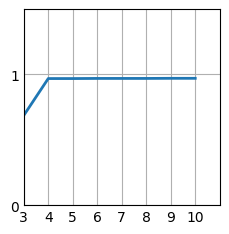

In [6]:
plt.style.use('_mpl-gallery')

# make data
x = [3, 4, 5, 6, 7, 8, 9, 10]
y = results.Precision.values

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

ax.set(xlim=(3, 11), xticks=np.arange(3, 11),
       ylim=(0, 1.5), yticks=np.arange(0, 1.5))

plt.show()

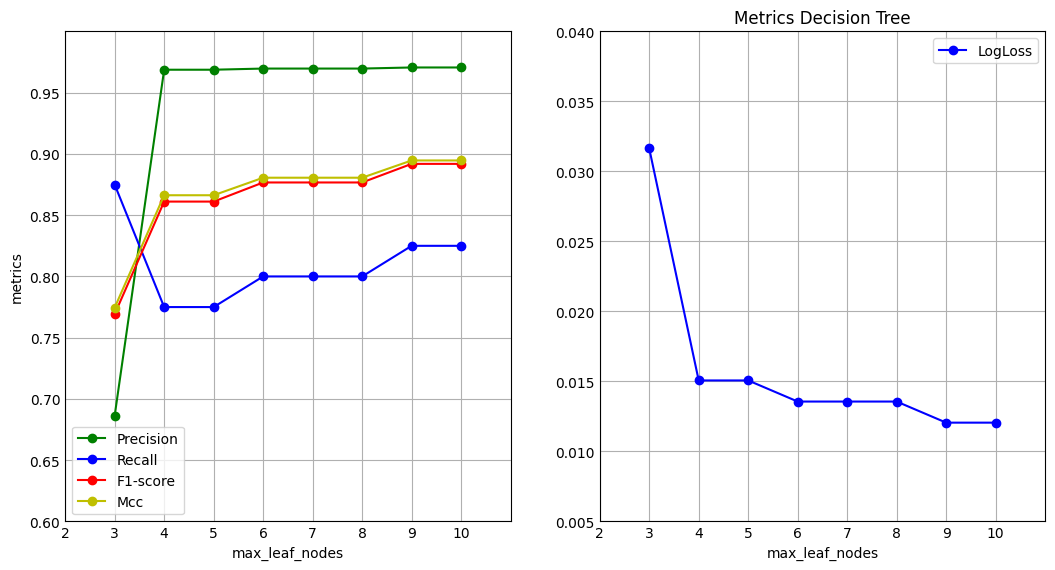

In [50]:
import numpy as np
import matplotlib.pyplot as plt


x = [3, 4, 5, 6, 7, 8, 9, 10]
y1 = results.Precision.values
y2 = results.Recall.values
y3 = results["F1-score"].values
y4 = results.LogLoss.values
y5 = results.Mcc.values

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(x, y1, 'g-o', label = "Precision")
ax1.plot(x, y2, 'b-o', label = "Recall")
ax1.plot(x, y3, 'r-o', label = "F1-score")
ax2.plot(x, y4, 'b-o', label = "LogLoss")
ax1.plot(x, y5, 'y-o', label = "Mcc")
plt.legend()


ax2.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
ax2.set_title('Log loss')
ax1.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.6, 1), yticks=np.arange(0.6, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
ax1.legend()

plt.title("Metrics Decision Tree")

plt.legend()
plt.show()

In [48]:
np.arange(0.6, 1, 0.05)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

# Random Forest Classifier

In [8]:
first_model_forest = RandomForestClassifier(random_state=1)
first_model_forest.fit(train_X, train_y)
first_model_forest_predicted = first_model_forest.predict(val_X)
report(val_y, first_model_forest_predicted, "Random Forest Classifier", "first simple model", csvw = True)

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Random Forest Classifier,first simple model,2023-04-26 17:27:30.691953,0.916667,0.825,0.868421,0.015071,0.869421


In [9]:
model_1 = RandomForestClassifier(n_estimators=50, random_state=1)
model_2 = RandomForestClassifier(n_estimators=100, random_state=1)
model_3 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=1)
model_4 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=1)

models = [model_1, model_2, model_3, model_4]
desc_model = ["n_estimators=50, random_state=1","n_estimators=100, random_state=1",
              "n_estimators=200, min_samples_split=20, random_state=1", "n_estimators=100, max_depth=7, random_state=1"]

# Function for comparing different models
def score_model(model, train_X, val_X, train_y, val_y, desc_model):
    model.fit(train_X, train_y)
    preds = model.predict(val_X)
    metrics = report(val_y, preds, "Random Forest Classifier", desc_model, csvw=True)
    return metrics

for i in range(0, len(models)):
    my_metrics_forest = score_model(models[i], train_X, val_X, train_y, val_y, desc_model[i])
    print(my_metrics_forest)

                      Model                      Description   
0  Random Forest Classifier  n_estimators=50, random_state=1  \

                        Date  Precision  Recall  F1-score   LogLoss       Mcc  
0 2023-04-26 17:27:32.003638   0.846154   0.825  0.835443  0.019592  0.835238  
                      Model                       Description   
0  Random Forest Classifier  n_estimators=100, random_state=1  \

                        Date  Precision  Recall  F1-score   LogLoss       Mcc  
0 2023-04-26 17:27:34.507217   0.916667   0.825  0.868421  0.015071  0.869421  
                      Model   
0  Random Forest Classifier  \

                                         Description   
0  n_estimators=200, min_samples_split=20, random...  \

                        Date  Precision  Recall  F1-score   LogLoss       Mcc  
0 2023-04-26 17:27:39.205993   0.846154   0.825  0.835443  0.019592  0.835238  
                      Model                                    Description   
0  Ran

In [10]:
showreportcsv()

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,NaN,Table init,2023-04-26 16:55:24.655508,0.000000,0.000,0.000000,0.000000,0.000000
4,Decision Tree Classifier,max_leaf_nodes : 500; random_state = 1,2023-04-26 16:55:31.677039,0.970588,0.825,0.891892,0.012057,0.894680
5,Decision Tree Classifier,max_leaf_nodes : 5000; random_state = 1,2023-04-26 16:55:31.747389,0.970588,0.825,0.891892,0.012057,0.894680
36,Decision Tree Classifier,max_leaf_nodes : 20; random_state = 1,2023-04-26 17:06:19.980611,0.970588,0.825,0.891892,0.012057,0.894680
37,Decision Tree Classifier,max_leaf_nodes : 30; random_state = 1,2023-04-26 17:06:20.042869,0.970588,0.825,0.891892,0.012057,0.894680
38,Decision Tree Classifier,max_leaf_nodes : 40; random_state = 1,2023-04-26 17:06:20.117440,0.970588,0.825,0.891892,0.012057,0.894680
39,Decision Tree Classifier,max_leaf_nodes : 50; random_state = 1,2023-04-26 17:06:20.191369,0.970588,0.825,0.891892,0.012057,0.894680
40,Decision Tree Classifier,max_leaf_nodes : 100; random_state = 1,2023-04-26 17:06:20.269820,0.970588,0.825,0.891892,0.012057,0.894680
55,Decision Tree Classifier,first simple model,2023-04-26 17:27:27.421869,0.916667,0.825,0.868421,0.015071,0.869421
56,Decision Tree Classifier,max_leaf_nodes : 3; random_state = 1,2023-04-26 17:27:27.508800,0.686275,0.875,0.769231,0.031649,0.774498


In [11]:
df = pd.read_csv('evaluationmetric.csv')
df

,Unnamed: 0,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,0,NaN,Table init,2023-04-26 16:55:24.655508,0.000000,0.000,0.000000,0.000000,0.000000
1,0,Decision Tree Classifier,first simple model,2023-04-26 16:55:31.327444,0.916667,0.825,0.868421,0.015071,0.869421
2,0,Decision Tree Classifier,max_leaf_nodes : 5; random_state = 1,2023-04-26 16:55:31.546606,0.968750,0.775,0.861111,0.015071,0.866284
3,0,Decision Tree Classifier,max_leaf_nodes : 50; random_state = 1,2023-04-26 16:55:31.611596,0.970588,0.825,0.891892,0.012057,0.894680
4,0,Decision Tree Classifier,max_leaf_nodes : 500; random_state = 1,2023-04-26 16:55:31.677039,0.970588,0.825,0.891892,0.012057,0.894680
...,...,...,...,...,...,...,...,...,...
64,0,Random Forest Classifier,first simple model,2023-04-26 17:27:30.691953,0.916667,0.825,0.868421,0.015071,0.869421
65,0,Random Forest Classifier,"n_estimators=50, random_state=1",2023-04-26 17:27:32.003638,0.846154,0.825,0.835443,0.019592,0.835238
66,0,Random Forest Classifier,"n_estimators=100, random_state=1",2023-04-26 17:27:34.507217,0.916667,0.825,0.868421,0.015071,0.869421
67,0,Random Forest Classifier,"n_estimators=200, min_samples_split=20, random...",2023-04-26 17:27:39.205993,0.846154,0.825,0.835443,0.019592,0.835238
